In [48]:
%load_ext autoreload
%autoreload 2


from sklearn.linear_model import LogisticRegression, LinearRegression

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from logistic_regression import logistic
from scipy.stats.mstats import mquantiles
import seaborn as sns
import scipy.stats
from plot_utils import PlotInfo, save_freq_acc_plot_and_get_info, save_logistic_regression_lines_plot_for_shots, save_logistic_regression_lines_plot_for_models, frequency_cache_singleton

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
sns.set_theme(style="white", palette="pastel")

In [ ]:
WORD = 'week'
MODEL = 'gptj'
for shots in [2, 4, 8, 20]:
    a = save_freq_acc_plot_and_get_info(WORD, shots, MODEL, key='x', show_plot = True)
    print(shots, ":", a.accuracy_all)


In [ ]:
q = save_freq_acc_plot_and_get_info('day', 2, 'gptj', key='xz', show_plot = True, quantile_number=2)

In [ ]:
save_logistic_regression_lines_plot_for_shots('plus', 'gptj', shots=[0, 2,4, 8, 20], key='xz', show_plot=True)

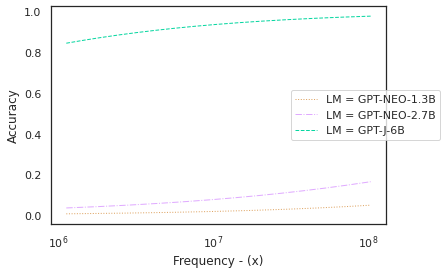

In [97]:
save_logistic_regression_lines_plot_for_models('plus', ['gptjsmall', 'gptjlarge', 'gptj'], shot=2, key='x', show_plot=True)

## For Latex Results

In [132]:

def create_arithmetics_similarity_1():
    arithmetics_task_1_path = './latex_results/arithmetics-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Multiplication', 'mult'), ('Addition', 'plus')]:
        task_result = []
        for model in ['gptj']:
            for shot in [0, 2, 4, 8, 20]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                result['Similarity_xz'].append(
                    PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(arithmetics_task_1_path)
    print(latex_content)


create_arithmetics_similarity_1()




I'm at index 9999999, lines: (('274087', '300671'), 1)

\multirow{5}{*}{Multiplication} & 0 & 0.05 & 0.18 & 0.21\\
& 2 & 0.37 & 0.72 & 0.78\\
& 4 & 0.39 & 0.67 & 0.76\\
& 8 & 0.41 & 0.71 & 0.78\\
& 20 & 0.40 & 0.79 & 0.80\\
\midrule
\multirow{5}{*}{Addition} & 0 & 0.02 & 0.08 & 0.07\\
& 2 & 0.90 & 0.13 & 0.17\\
& 4 & 0.92 & 0.09 & 0.16\\
& 8 & 0.92 & 0.15 & 0.24\\
& 20 & 0.86 & 0.19 & 0.30\\
\midrule



In [133]:

def create_comparison_similarity_1():
    comparison_task_1_path = './latex_results/comparison-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Min', 'compareless'), ('Max', 'comparemore')]:
        task_result = []
        for model in ['gptj']:
            for shot in [0, 2, 4, 8, 20]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                result['Similarity_xz'].append(
                    PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(comparison_task_1_path)
    print(latex_content)


create_comparison_similarity_1()

\multirow{5}{*}{Min} & 0 & 0.00 & 0.02 & 0.00\\
& 2 & 0.56 & 0.60 & 0.03\\
& 4 & 0.69 & 0.10 & -0.14\\
& 8 & 0.78 & -0.11 & -0.15\\
& 20 & 0.86 & 0.07 & -0.14\\
\midrule
\multirow{5}{*}{Max} & 0 & 0.00 & 0.00 & 0.00\\
& 2 & 0.64 & 0.08 & -0.04\\
& 4 & 0.65 & -0.21 & 0.06\\
& 8 & 0.65 & -0.29 & 0.11\\
& 20 & 0.75 & -0.26 & -0.16\\
\midrule



In [134]:
def create_timeunits_similarity_1():
    timeunits_task_1_path = './latex_results/timeunits-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        # 'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Min2Sec', 'minute'), ('Hour2Min', 'hour'), ('Day2Hour', 'day'), ('Month2Week', 'month'), ('Year2Month', 'year'), ('Decade2Year', 'decade')]:
        task_result = []
        for model in ['gptj']:
            for shot in [2, 4, 8]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                # result['Similarity_xz'].append(
                #     PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(timeunits_task_1_path)
    with open(timeunits_task_1_path+".txt", "w") as f:
        f.write(latex_content)
    print(latex_content)


create_timeunits_similarity_1()

Total Not Found for key xy is 9
Total Not Found for key xy is 9
Total Not Found for key xy is 9
Total Not Found for key xy is 159
Total Not Found for key xy is 154
Total Not Found for key xy is 146
\multirow{3}{*}{Min2Sec} & 2 & 0.19 & 0.44 & 0.47\\
& 4 & 0.39 & 0.57 & 0.60\\
& 8 & 0.47 & 0.64 & 0.61\\
\midrule
\multirow{3}{*}{Hour2Min} & 2 & 0.22 & 0.57 & 0.49\\
& 4 & 0.26 & 0.58 & 0.52\\
& 8 & 0.38 & 0.70 & 0.61\\
\midrule
\multirow{3}{*}{Day2Hour} & 2 & 0.10 & 0.20 & 0.16\\
& 4 & 0.19 & 0.25 & 0.21\\
& 8 & 0.31 & 0.44 & 0.45\\
\midrule
\multirow{3}{*}{Month2Week} & 2 & 0.36 & 0.07 & 0.11\\
& 4 & 0.75 & 0.16 & 0.21\\
& 8 & 0.79 & 0.33 & 0.28\\
\midrule
\multirow{3}{*}{Year2Month} & 2 & 0.22 & 0.48 & 0.57\\
& 4 & 0.29 & 0.46 & 0.58\\
& 8 & 0.53 & 0.57 & 0.63\\
\midrule
\multirow{3}{*}{Decade2Year} & 2 & 0.75 & 0.29 & 0.27\\
& 4 & 0.96 & 0.02 & 0.02\\
& 8 & 1.00 & 0.00 & 0.00\\
\midrule



In [140]:
def create_generic_similarity_2(name: str, list_of_tasks, shots):
    generic_task_1_path = f'./latex_results/{name}-gptj-2.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}& {6:.2f} & {7:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}& {4:.2f} & {5:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    q_num = 10
    for (task, word) in list_of_tasks:
        task_result = []
        for model in ['gptj']:
            for shot in shots:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=q_num) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=q_num).similarity)
                result['Similarity_xz'].append(
                    PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=q_num).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1],result['Similarity_x'][-1]/result['Accuracy'][-1], result['Similarity_xy'][-1]/result['Accuracy'][-1]])
        latex_content += template_header.format(len(task_result), task, *task_result[0])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(generic_task_1_path)
    with open(generic_task_1_path+".txt", "w") as f:
        f.write(latex_content)
    print(latex_content)


create_generic_similarity_2("arithmetics", [('Multiplication', 'mult'), ('Addition', 'plus')], [0, 2, 4, 8, 20])
create_generic_similarity_2("comparison", [('Min', 'compareless'), ('Max', 'comparemore')], [0, 2, 4, 8, 20])
create_generic_similarity_2("timeunits", [('Min2Sec', 'minute'), ('Hour2Min', 'hour'), ('Day2Hour', 'day'), ('Month2Week', 'month'), ('Year2Month', 'year'), ('Decade2Year', 'decade')], [2, 4, 8])


\multirow{5}{*}{Multiplication} & 0 & 0.05 & 0.18 & 0.21& 3.31 & 3.80\\
& 2 & 0.37 & 0.72 & 0.78& 1.97 & 2.12\\
& 4 & 0.39 & 0.67 & 0.76& 1.71 & 1.94\\
& 8 & 0.41 & 0.71 & 0.78& 1.72 & 1.90\\
& 20 & 0.40 & 0.79 & 0.80& 1.97 & 1.99\\
\midrule
\multirow{5}{*}{Addition} & 0 & 0.02 & 0.08 & 0.07& 5.35 & 4.38\\
& 2 & 0.90 & 0.13 & 0.17& 0.15 & 0.19\\
& 4 & 0.92 & 0.09 & 0.16& 0.10 & 0.17\\
& 8 & 0.92 & 0.15 & 0.24& 0.16 & 0.26\\
& 20 & 0.86 & 0.19 & 0.30& 0.22 & 0.35\\
\midrule



/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


\multirow{5}{*}{Min} & 0 & 0.00 & 0.02 & 0.00& 9.18 & 0.51\\
& 2 & 0.56 & 0.60 & 0.03& 1.07 & 0.05\\
& 4 & 0.69 & 0.10 & -0.14& 0.15 & -0.20\\
& 8 & 0.78 & -0.11 & -0.15& -0.14 & -0.20\\
& 20 & 0.86 & 0.07 & -0.14& 0.08 & -0.16\\
\midrule
\multirow{5}{*}{Max} & 0 & 0.00 & 0.00 & 0.00& nan & nan\\
& 2 & 0.64 & 0.08 & -0.04& 0.12 & -0.06\\
& 4 & 0.65 & -0.21 & 0.06& -0.33 & 0.09\\
& 8 & 0.65 & -0.29 & 0.11& -0.45 & 0.18\\
& 20 & 0.75 & -0.26 & -0.16& -0.35 & -0.21\\
\midrule

Total Not Found for key xz is 206
Total Not Found for key xz is 201
Total Not Found for key xz is 194
Total Not Found for key xy is 9
Total Not Found for key xz is 347
Total Not Found for key xy is 9
Total Not Found for key xz is 340
Total Not Found for key xy is 9
Total Not Found for key xz is 324
Total Not Found for key xz is 230
Total Not Found for key xz is 228
Total Not Found for key xz is 215


/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Not Found for key xz is 207
Total Not Found for key xz is 204
Total Not Found for key xz is 194
Total Not Found for key xz is 221
Total Not Found for key xz is 214
Total Not Found for key xz is 206
Total Not Found for key xy is 159
Total Not Found for key xz is 251
Total Not Found for key xy is 154
Total Not Found for key xz is 246
Total Not Found for key xy is 146
Total Not Found for key xz is 229
\multirow{3}{*}{Min2Sec} & 2 & 0.19 & 0.54 & 0.54& 2.91 & 2.91\\
& 4 & 0.39 & 0.54 & 0.77& 1.38 & 1.95\\
& 8 & 0.47 & 0.65 & 0.73& 1.39 & 1.55\\
\midrule
\multirow{3}{*}{Hour2Min} & 2 & 0.22 & 0.65 & 0.36& 2.94 & 1.62\\
& 4 & 0.26 & 0.64 & 0.41& 2.47 & 1.57\\
& 8 & 0.38 & 0.71 & 0.48& 1.86 & 1.25\\
\midrule
\multirow{3}{*}{Day2Hour} & 2 & 0.10 & 0.25 & 0.20& 2.55 & 1.97\\
& 4 & 0.19 & 0.32 & 0.24& 1.72 & 1.29\\
& 8 & 0.31 & 0.55 & 0.47& 1.76 & 1.51\\
\midrule
\multirow{3}{*}{Month2Week} & 2 & 0.36 & -0.14 & -0.09& -0.38 & -0.24\\
& 4 & 0.75 & 0.17 & 0.15& 0.22 & 0.20\\
& 8 & 0.79 & 0.3

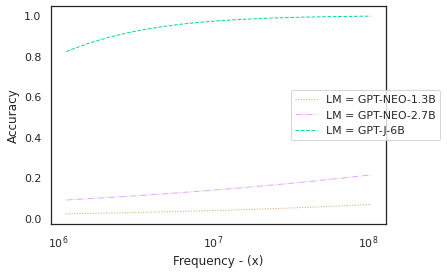

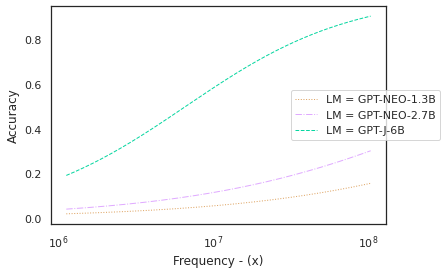

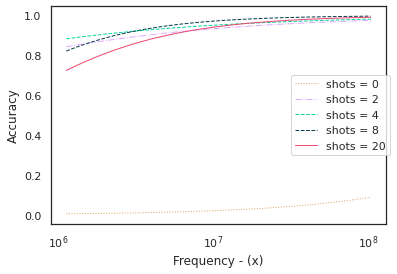

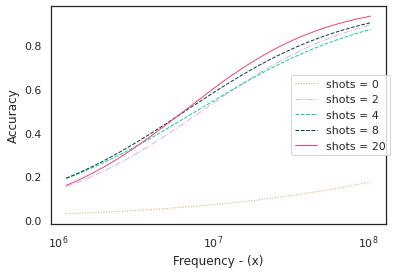

In [146]:
def draw_plots_1():
    save_logistic_regression_lines_plot_for_models('plus', ['gptjsmall', 'gptjlarge', 'gptj'], shot=8, key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_models('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shot=8, key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_shots('plus', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_shots('mult', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    for shot in [0, 2, 4, 8, 20]:
        save_freq_acc_plot_and_get_info('mult', shot, 'gptj', key='x', show_plot = False, quantile_number=10)

draw_plots_1()

Total Not Found for key xz is 215


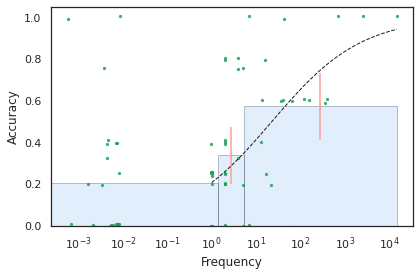

In [131]:
save_freq_acc_plot_and_get_info('day', 8, 'gptj', key='xz', show_plot=True, quantile_number=5)